In [1]:
!pip install -Uqq duckduckgo_search

In [1]:
from pathlib import Path
from time import sleep

from duckduckgo_search import ddg_images
from fastcore.all import *

In [2]:
def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot("image")

In [3]:
urls = search_images("baseball bat", max_images=1)
urls[0]

'https://i5.walmartimages.com/asr/db58db17-4ccd-4c13-b46f-3c9fb3e062e0_1.37902d6185c021734c35acfe653cc7d9.jpeg'

## Instead of bird and forest, it is cricket bat vs baseball bat vs tennis racket

In [4]:
from fastdownload import download_url
dest = "./resources/baseball_bat.jpg"
download_url(urls[0], dest)

Path('resources/baseball_bat.jpg')

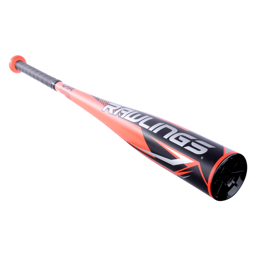

In [5]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

In [6]:
urls = search_images("cricket bat", max_images=1)
urls[0]

'https://res-5.cloudinary.com/s247/image/upload/c_pad,dpr_1.0,f_auto,q_auto/media/catalog/product/w/o/woodworm-cricket-ib-select-grade-1-cricket-bat.png'

In [7]:
dest = "./resources/cricket_bat.jpg"
download_url(urls[0], dest)

Path('resources/cricket_bat.jpg')

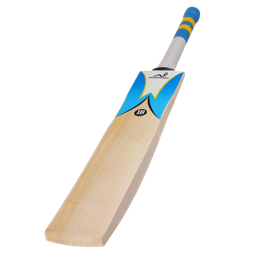

In [8]:
Image.open(dest).to_thumb(256, 256)

In [9]:
# downloading multiple images of each of the category

In [11]:
categories = ["cricket bat", "baseball bat", "tennis racket"]
path = Path("./resources/which_bat")

In [36]:
for cat in categories:
    dest = path/cat
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{cat} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"playing with {cat} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"posing with {cat} photo"))

In [14]:
# added max_workers argument in below code, as the earlier was raising exception broken process pool 

In [13]:
for cat in categories:
    resize_images(path/cat, max_size=400, dest=path/cat, max_workers=1)

## Traing the model

In [22]:
!pip install nbdev

In [25]:
file_paths = get_image_files(path)
failed = verify_images(file_paths)
failed.map(Path.unlink)
len(failed)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.